In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os

In [4]:
os.getcwd()

'/kaggle/working'

In [5]:
#os.removedirs('/kaggle/working/Recurent_model')
os.mkdir('Recurent_model')
os.mkdir('Convloution_model')

In [6]:
os.chdir('/kaggle/input/chapmanshaoxing-12lead-ecg-database/WFDB_ChapmanShaoxing')

In [7]:
import matplotlib.pyplot as plt
from tensorflow import data 
import wfdb as sig
import keras
from keras.models import Sequential , load_model
from keras.layers import Dense,BatchNormalization, Activation, Dropout, Conv1D, GlobalAveragePooling1D, MaxPooling1D , SimpleRNN , LSTM , Input
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint , EarlyStopping
from keras.optimizers import Adam
import seaborn as sns
#from keras.utils import np_utils

2024-05-18 21:36:35.150874: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 21:36:35.150970: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 21:36:35.291825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
def find_the_best_threshold(model , X, Y ):
    """
    To find the best threshold I need the model , X , Y to selct the best threshold passed on acciracy
    The function return a list of tuble the sample of tuple (accuracy at threshold , threshold )
   """
    threshold_VS_accuracy = []
    Thresholds = np.linspace(0,1 ,100)
    Predection = model(X).numpy()
    for Threshold in Thresholds:
        Y_hat = Predection >= Threshold
        Y_hat = Y_hat.reshape((-1,))
        True_rate =  Y_hat == Y
        threshold_VS_accuracy.append((Threshold ,  True_rate.sum()))
    return threshold_VS_accuracy

In [9]:
def evaluate(Predection, X ,Y, threshold):
    """
    This function evaluate True postive rate  , False postive rate at a certain threshold.
    This function is used to evaluate the ROC curve.
    This function return (FP_rate , TP_rate)
    """
    condition = Predection >=threshold
    Y_hat =condition.reshape((-1,))
    TP = Y_hat[Y==1].sum()
    TP_rate = TP / len(Y_hat[Y==1])
    FP = Y_hat[Y==0].sum()
    FP_rate = FP/len(Y_hat[Y==0])
    #return FP , TP          #Test Condition
    return FP_rate , TP_rate

In [10]:
def AUC_For_model(ROC_Pair):
    """
    This Function is used to evaluate the area under ROC curve which used to evaluate the model
    bassed on ROC curve.
    return AUC
    """
    AUC = 0
    for i in range(1 , len(ROC_Pair)):
        AUC += abs(ROC_Pair[i,0] - ROC_Pair[i-1,0] ) * (ROC_Pair[i,1] + ROC_Pair[i-1,1] )
    return AUC/2

In [11]:
def ROC_Pair_FN(model ,X , Y):
    """
    This function is uesed in ploting the ROC curve
    This function needs model , X , Y
    output (FP_rate , TP_rate )
    """
    Predection  = model(X).numpy()
    Thresholds = np.linspace(0,1 ,100)
    ROC_pair = []
    for Threshold in Thresholds:
        pair = evaluate(Predection , X , Y , Threshold)
        ROC_pair.append(pair)
    return np.c_[np.array(ROC_pair) , Thresholds]
    

In [12]:
def preprocess(dat):
  """
  This function read the data from directory and store it with label in numpy array
  Input DataFrame contain directory and label as columns
  Output two numpy array one for X , and one for y
  """
    data_dir = list(dat['directory'])
    data_signal = map(read_signal , data_dir)
    data_signal = list(data_signal)
    data_signal = np.array(data_signal)
    data_dict = {'SR' : 0 , 'SB': 1  }
    encoded_label = dat['diagnosis'].map(data_dict)
    return np.array(data_signal)  , np.array(encoded_label)

In [13]:
def read_signal(directory):
  """
  The function is used to read signal from its directory
  The function takes the directory as input 
  The function output is a signal in form of numpy array
  
  """
    signal  = wfdb.rdrecord(directory,sampfrom=0 , sampto=5000)
    signal = signal.__dict__['p_signal'][::,0]
    return signal

'SR'

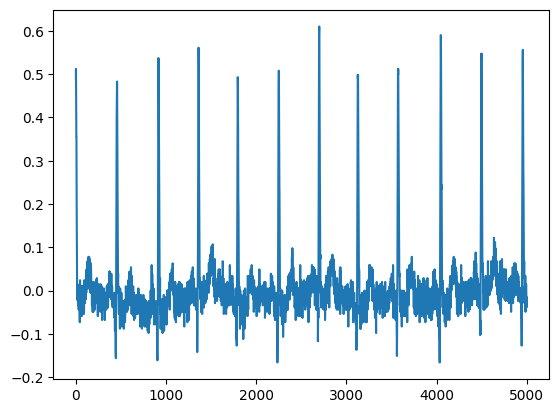

In [14]:
df = pd.read_csv('/kaggle/input/my-dir/imp.csv').iloc[:: , 1:3]
train , test = train_test_split(df , train_size=.8 ,random_state=1002)
train.reset_index(inplace = True)
test.reset_index(inplace = True)
plt.plot(read_signal(train['directory'][0]))
train['diagnosis'][0]

In [15]:
Class_summary = df.groupby('diagnosis').count() * 100 / len(df)
Class_summary

,directory
diagnosis,
SB,61.715247
SR,38.284753


### Data preperation for model

### Label preperation for model 

In [16]:
x_train , y_train = preprocess(train)
x_test  , y_test  = preprocess(test)  

In [31]:
optimizer = Adam()
Recurent_model = Sequential()
Recurent_model.add(Input(shape = (100 , 50)))
Recurent_model.add(LSTM(64))
Recurent_model.add(Dense(32 , activation= 'relu'))
Recurent_model.add(Dense(1 , activation= 'sigmoid'))
Recurent_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
Recurent_model_x_train = x_train.reshape((-1 ,100 , 50))
Recurent_model_x_test  = x_test.reshape((-1 ,100 , 50))

In [33]:
Recurent_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,553 (123.25 KB)

 Trainable params: 31,553 (123.25 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
Best_Recurent_model_directory = '/kaggle/working/Recurent_model/best.keras'
Best_Recurent_model_checkpoint = ModelCheckpoint(
    filepath=Best_Recurent_model_directory ,save_best_only=True 
)

In [35]:
Recurent_model_hist = Recurent_model.fit(x = Recurent_model_x_train , y = y_train , batch_size= 32 , epochs =  50 ,validation_data=(Recurent_model_x_test, y_test),
         callbacks = [Best_Recurent_model_checkpoint])

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6045 - loss: 0.6764 - val_accuracy: 0.6092 - val_loss: 0.6731
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6153 - loss: 0.6599 - val_accuracy: 0.6134 - val_loss: 0.6605
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6408 - loss: 0.6364 - val_accuracy: 0.6120 - val_loss: 0.6583
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6589 - loss: 0.6152 - val_accuracy: 0.6751 - val_loss: 0.5996
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7118 - loss: 0.5588 - val_accuracy: 0.7857 - val_loss: 0.4381
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8098 - loss: 0.3978 - val_accuracy: 0.8697 - val_loss: 0.3248
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8771 - loss: 0.2959 - val_accuracy: 0.9020 - val_loss: 0.2413
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9090 - loss: 0.2152 - val_accuracy: 0.9230 - val_loss

In [37]:
Recurent_model.save('/kaggle/working/Recurent_model/Last.keras')

In [38]:
best_Recurent_model = load_model('/kaggle/working/Recurent_model/best.keras')
ROC_For_best_Recurent_model = ROC_Pair_FN(best_Recurent_model ,Recurent_model_x_test,y_test )

In [77]:
from keras.utils import plot_model

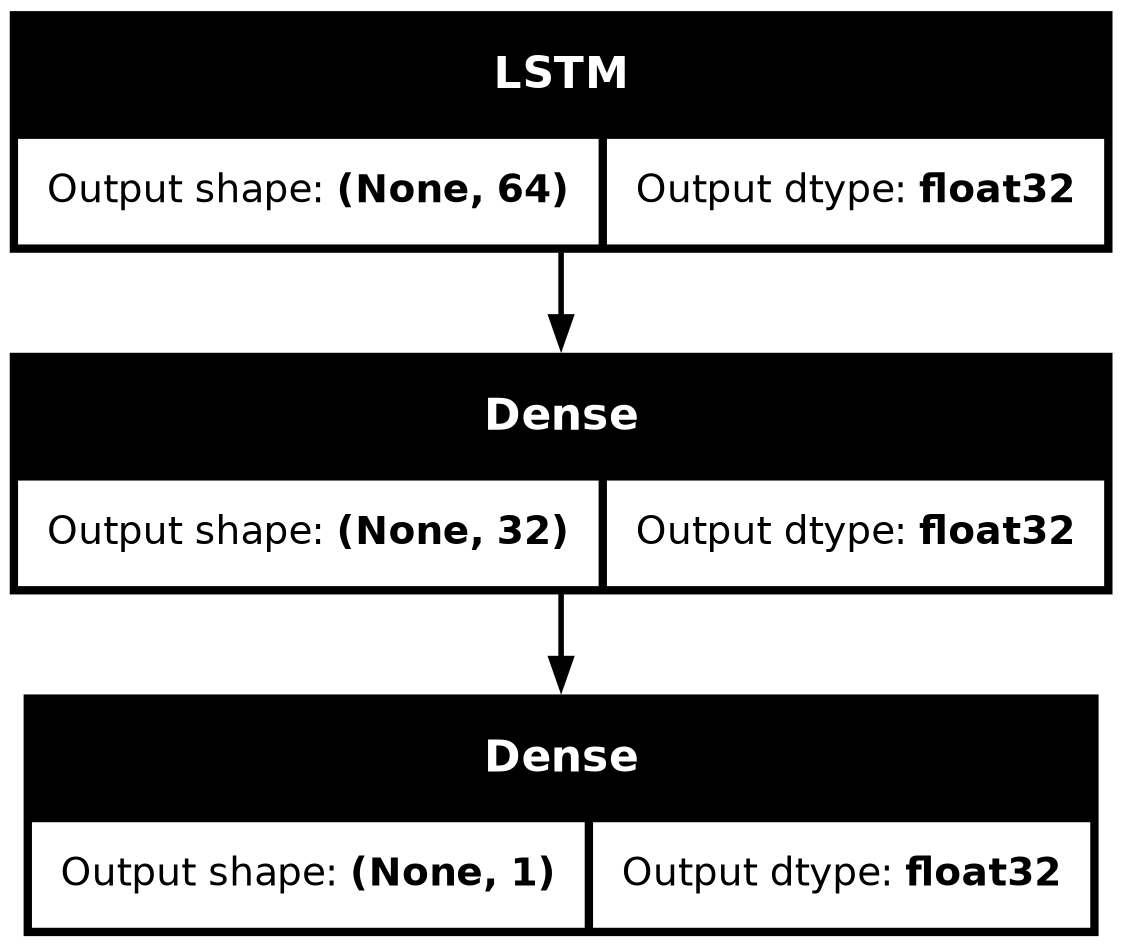

In [83]:
plot_model(best_Recurent_model ,  to_file='/kaggle/working/model.png', show_shapes=True,
    show_dtype=True) 

In [76]:
best_Recurent_model.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,661 (369.77 KB)

 Trainable params: 31,553 (123.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,108 (246.52 KB)

In [39]:
ROC_For_Recurent_model = ROC_Pair_FN(Recurent_model , Recurent_model_x_test,y_test)

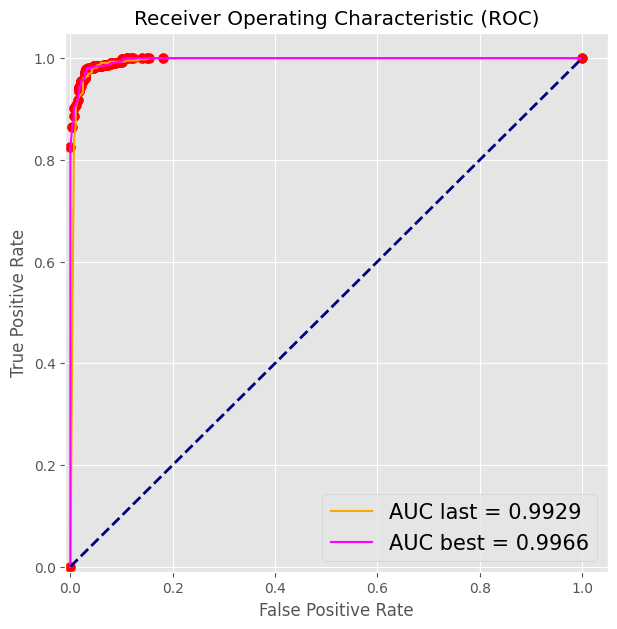

In [40]:
plt.figure(figsize=(7,7))
plt.style.use('ggplot')
plt.scatter(ROC_For_best_Recurent_model [:: , 0] , ROC_For_best_Recurent_model [:: ,1 ]  , marker = '.' , c = 'red',s =200)
plt.plot(ROC_For_Recurent_model[::,0] , ROC_For_Recurent_model[:: , 1]  , c = 'orange' ,  label = f"AUC last = {AUC_For_model(ROC_For_Recurent_model):.4f}" )
plt.plot(ROC_For_best_Recurent_model [:: , 0] ,  ROC_For_best_Recurent_model [:: , 1], c = 'magenta' , label = f"AUC best = {AUC_For_model(ROC_For_best_Recurent_model):.4f}" )
plt.plot([0,1.001] , [0,1.001 ]  ,lw=2, linestyle='--' , color = 'navy'  )
plt.xlim([-0.01, 1.05])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right" ,fontsize="15" )
plt.show()


### From ROC Curve the best model and last model seems to be identical
### The best model gives the least loss 
### We will use the best model

### Searching for best Threshold

In [41]:
Threshold_vs_accuracy_In_Recurent_model = find_the_best_threshold(best_Recurent_model , Recurent_model_x_test , y_test ) 

In [42]:
Threshold_vs_accuracy_In_Recurent_model  = np.array(Threshold_vs_accuracy_In_Recurent_model)
condition = Threshold_vs_accuracy_In_Recurent_model[:: , 1] ==Threshold_vs_accuracy_In_Recurent_model[:: , 1].max()
Threshold_vs_accuracy_In_Recurent_model[condition,0]
Recurent_model_accuracy = Threshold_vs_accuracy_In_Recurent_model[:: , 1].max() / len(y_test)
print(Recurent_model_accuracy)

0.9747899159663865


In [43]:
Threshold_vs_accuracy_In_Recurent_model[condition,0]


array([0.53535354, 0.58585859])

### Confusion matrix for best threshold 
### We will choose 0.56565657

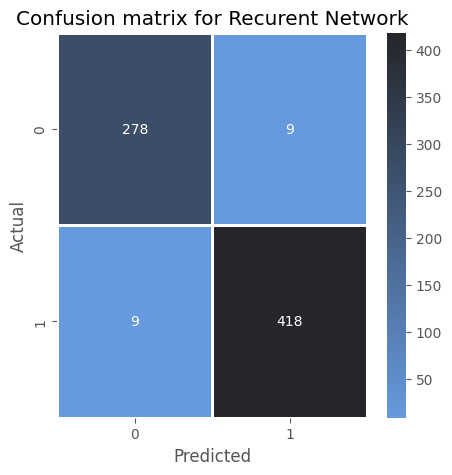

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
Y_hat = best_Recurent_model(Recurent_model_x_test) >=0.58585859
plt.figure(figsize=(5,5))
plt.title("Confusion matrix for Recurent Network")
sns.heatmap(confusion_matrix(y_test , Y_hat ),cmap = sns.dark_palette("#69d",10, reverse=True, as_cmap=True),annot=True,linewidth=1 ,fmt=".0f");
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [49]:
from sklearn.metrics import f1_score
print(f"F1_Score For Recurrent Model= {f1_score(y_test , Y_hat) }")

F1_Score For Recurrent Model= 0.9789227166276346


### 1D convloution model

In [63]:
CNN_model = Sequential()
CNN_model.add(Conv1D(128, 55, activation='relu', input_shape=(5000, 1)))
CNN_model.add(MaxPooling1D(10))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(128, 25, activation='relu'))
CNN_model.add(MaxPooling1D(5))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(128, 10, activation='relu'))
CNN_model.add(MaxPooling1D(5))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(128, 5, activation='relu'))
CNN_model.add(GlobalAveragePooling1D())
# model.add(Flatten())
CNN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(128, kernel_initializer='normal', activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(64, kernel_initializer='normal', activation='relu'))
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
CNN_model.compile(loss = 'binarycrossentropy')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [64]:

opt  = keras.optimizers.Adam(.001)
metrics = [keras.metrics.Accuracy()]
CNN_model.compile(loss =keras.losses.binary_crossentropy  , optimizer= opt , metrics = ['accuracy']  )

In [65]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

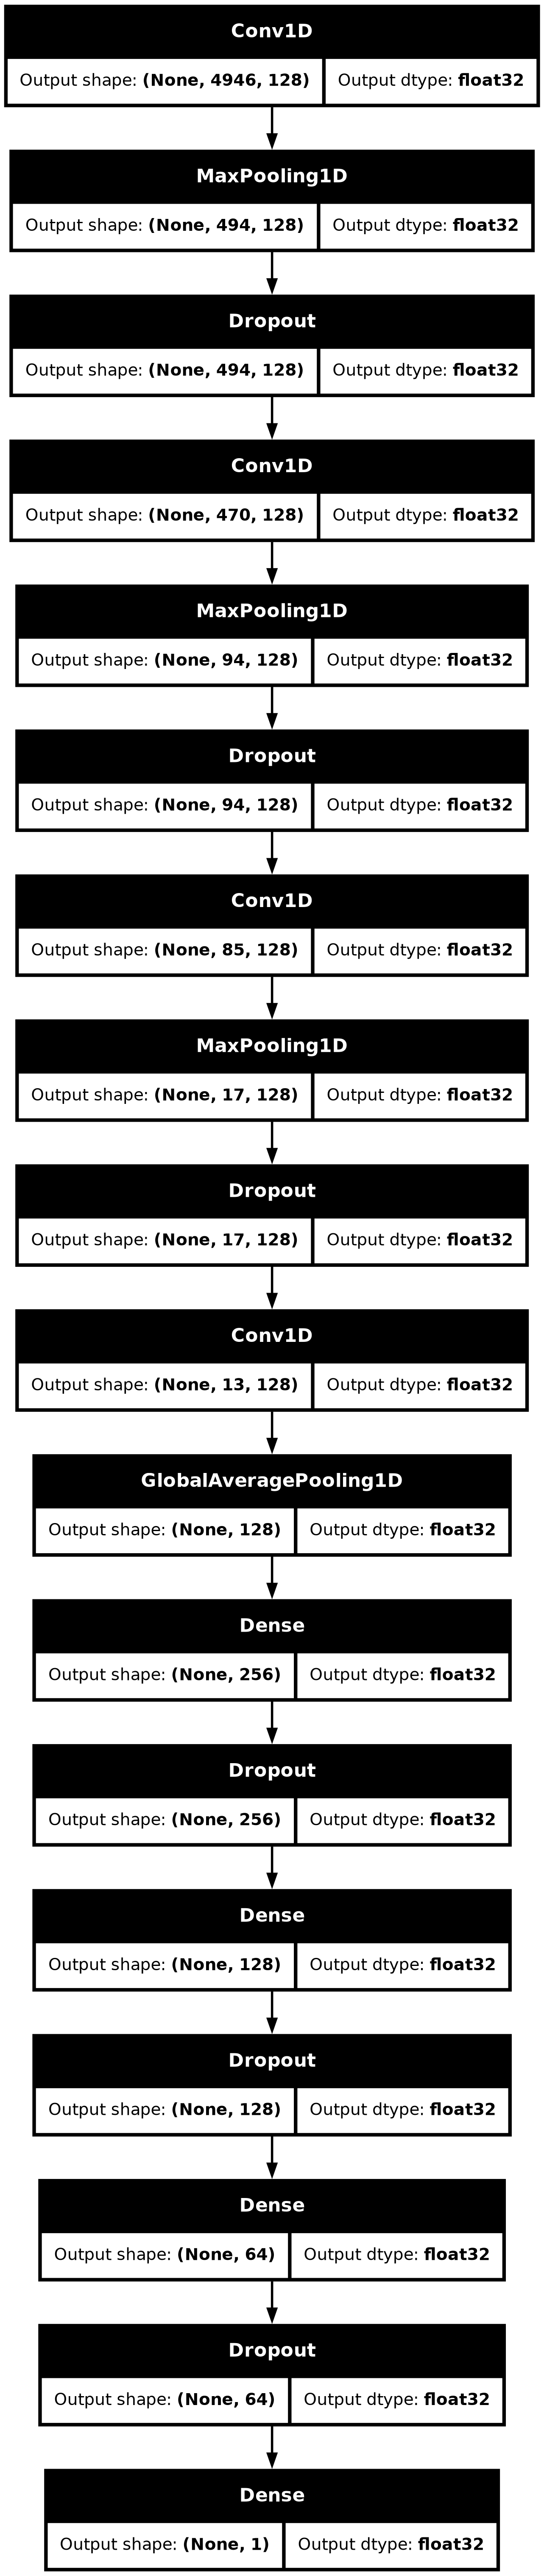

In [84]:
plot_model(CNN_model ,  to_file='/kaggle/working/CNN.png', show_shapes=True,
    show_dtype=True)

In [66]:
CNN_hist = CNN_model.fit(x = x_train , y = y_train , batch_size= 32 , epochs =  50 ,validation_data=(x_test , y_test) , callbacks= [early_stopping] )

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step - accuracy: 0.6116 - loss: 0.6610 - val_accuracy: 0.9664 - val_loss: 0.3887
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9039 - loss: 0.2718 - val_accuracy: 0.9846 - val_loss: 0.0586
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9842 - loss: 0.0598 - val_accuracy: 0.9804 - val_loss: 0.0467
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9859 - loss: 0.0382 - val_accuracy: 0.9902 - val_loss: 0.0612
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9874 - loss: 0.0460 - val_accuracy: 0.9846 - val_loss: 0.0362
Epoch 6/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9837 - loss: 0.0497 - val_accuracy: 0.9790 - val_loss: 0.0465
Epoch 7/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9914 - loss: 0.0393 - val_accuracy: 0.9846 - val_loss: 0.0312
Epoch 8/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9913 - loss: 0.0311 - val_accuracy: 0.9860 -

In [67]:
predictions = CNN_model.predict(x_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


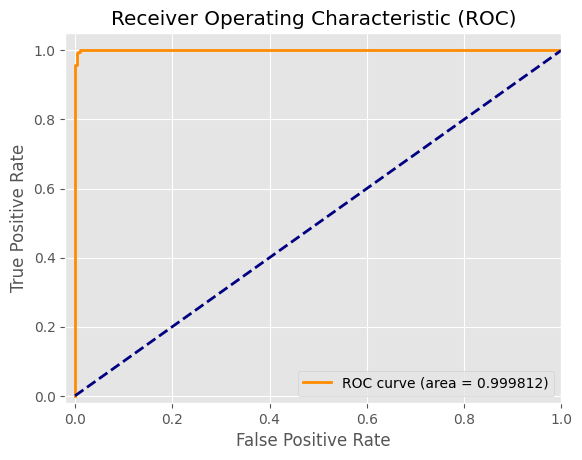

In [68]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test,predictions )
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.6f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [69]:
accuracy_Vs_Threshold_IN_CNN_model = np.array(find_the_best_threshold(CNN_model , x_test, y_test ))/[1 , 714]

In [70]:
best_threshold_for_CNN_filter = accuracy_Vs_Threshold_IN_CNN_model[:: , 1] == accuracy_Vs_Threshold_IN_CNN_model[:: , 1].max() 
best_threshold_for_CNN = accuracy_Vs_Threshold_IN_CNN_model[best_threshold_for_CNN_filter ]
best_threshold_for_CNN

array([[0.66666667, 0.99579832],
       [0.67676768, 0.99579832],
       [0.68686869, 0.99579832],
       [0.6969697 , 0.99579832],
       [0.70707071, 0.99579832],
       [0.71717172, 0.99579832],
       [0.72727273, 0.99579832],
       [0.73737374, 0.99579832]])

In [74]:
print(f"F1 score for CNN model = {f1_score(y_test , Y_hat )}")

F1 score for CNN model = 0.9964994165694282


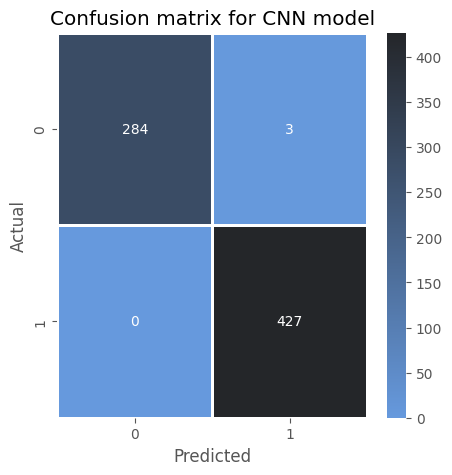

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
Y_hat = CNN_model(x_test) >=  0.66666667
plt.figure(figsize=(5,5))
plt.title('Confusion matrix for CNN model')
sns.heatmap(confusion_matrix(y_test , Y_hat ),cmap = sns.dark_palette("#69d",10, reverse=True, as_cmap=True),annot=True,linewidth=1 ,fmt=".0f");
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [72]:
CNN_model.save('/kaggle/working/Convloution_model/CNN_model.keras')